In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
 #!/bin/bash
!kaggle datasets download ismailpromus/skin-diseases-image-dataset

Dataset URL: https://www.kaggle.com/datasets/ismailpromus/skin-diseases-image-dataset
License(s): copyright-authors


In [ ]:
import zipfile

zip_ref = zipfile.ZipFile('/content/skin-diseases-image-dataset.zip', 'r')  # Open the zip file in read mode
zip_ref.extractall('/content')  # Extract all contents into the /content directory
zip_ref.close()  # Close the zip file to free resources


In [ ]:
!pip install split_folders

In [ ]:
import os
import random
import shutil
from PIL import Image, ImageOps, ImageEnhance
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === STEP 1: Balance and Split Dataset ===
IMG_DIR = '/content/IMG_CLASSES'  # your dataset folder with class subfolders
TARGET_PER_CLASS = 2500
TRAIN_RATIO = 0.8
OUTPUT_DIR = '/content/dataset_balanced'

def augment_image(img_path):
    img = Image.open(img_path).convert('RGB').resize((224, 224))
    if random.random() > 0.5: img = ImageOps.mirror(img)
    if random.random() > 0.5: img = ImageOps.flip(img)
    if random.random() > 0.5: img = img.rotate(random.randint(-20, 20))
    if random.random() > 0.5: img = ImageEnhance.Brightness(img).enhance(random.uniform(0.8, 1.2))
    return img

def balance_and_split():
    if os.path.exists(OUTPUT_DIR): shutil.rmtree(OUTPUT_DIR)
    os.makedirs(f'{OUTPUT_DIR}/train', exist_ok=True)
    os.makedirs(f'{OUTPUT_DIR}/val', exist_ok=True)

    for class_name in os.listdir(IMG_DIR):
        class_path = os.path.join(IMG_DIR, class_name)
        if not os.path.isdir(class_path): continue

        all_images = os.listdir(class_path)
        os.makedirs(f'{OUTPUT_DIR}/train/{class_name}', exist_ok=True)
        os.makedirs(f'{OUTPUT_DIR}/val/{class_name}', exist_ok=True)

        # Balance class
        while len(all_images) < TARGET_PER_CLASS:
            img_to_aug = random.choice(all_images)
            aug_img = augment_image(os.path.join(class_path, img_to_aug))
            new_name = f'aug_{random.randint(0, 99999)}.jpg'
            aug_img.save(os.path.join(class_path, new_name))
            all_images.append(new_name)
        if len(all_images) > TARGET_PER_CLASS:
            all_images = random.sample(all_images, TARGET_PER_CLASS)

        # Split 80/20
        random.shuffle(all_images)
        train_imgs = all_images[:int(TRAIN_RATIO * TARGET_PER_CLASS)]
        val_imgs = all_images[int(TRAIN_RATIO * TARGET_PER_CLASS):]

        for img in train_imgs:
            shutil.copy(os.path.join(class_path, img), f'{OUTPUT_DIR}/train/{class_name}/{img}')
        for img in val_imgs:
            shutil.copy(os.path.join(class_path, img), f'{OUTPUT_DIR}/val/{class_name}/{img}')

balance_and_split()

# === STEP 2: Load Datasets ===
train_ds = tf.keras.utils.image_dataset_from_directory(
    f'{OUTPUT_DIR}/train', image_size=(224, 224), batch_size=32, label_mode='categorical', shuffle=True, seed=42
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    f'{OUTPUT_DIR}/val', image_size=(224, 224), batch_size=32, label_mode='categorical', shuffle=False, seed=42
)
class_names = train_ds.class_names

# === STEP 3: Prefetch ===
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

# === STEP 4: Data Augmentation ===
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),
], name="data_augmentation")

# === STEP 5: Load Pretrained Model ===
base_model = tf.keras.applications.EfficientNetB7(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in base_model.layers[:-30]:
    layer.trainable = False

# === STEP 6: Build Final Model ===
inputs = layers.Input(shape=(224, 224, 3))
x = data_aug(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation='softmax', dtype='float32')(x)
model = Model(inputs, outputs)

# === STEP 7: Compile ===
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

# === STEP 8: Train ===
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)


Found 19987 files belonging to 10 classes.
Found 5000 files belonging to 10 classes.
258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step
Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 420s 598ms/step - accuracy: 0.3526 - auc: 0.7927 - loss: 2.0604 - precision: 0.4375 - recall: 0.2633 - val_accuracy: 0.5674 - val_auc: 0.9279 - val_loss: 1.1318 - val_precision: 0.7093 - val_recall: 0.4274 - learning_rate: 1.0000e-04
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 368s 582ms/step - accuracy: 0.4990 - auc: 0.8953 - loss: 1.4236 - precision: 0.5898 - recall: 0.4002 - val_accuracy: 0.6120 - val_auc: 0.9383 - val_loss: 1.0435 - val_precision: 0.7376 - val_recall: 0.4868 - learning_rate: 1.0000e-04
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 383s 613ms/step - accuracy: 0.5407 - auc: 0.9142 - loss: 1.2731 - precision: 0.6316 - recall: 0.4487 - val_accuracy: 0.6420 - val_auc: 0.9480 - val_loss: 0.9607 - val_precision: 0.7582 - val_recall: 0.5254 - learning_rate: 1.0000e-04
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Step 1: Predict
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Step 2: True labels
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

# Step 3: Get all labels used in true or predicted
all_labels = sorted(np.unique(np.concatenate((y_true, y_pred_classes))))

# Step 4: Match class names
filtered_class_names = [class_names[i] for i in all_labels]

# Step 5: Generate report
report = classification_report(y_true, y_pred_classes, labels=all_labels, target_names=filtered_class_names, zero_division=0)

print("Classification Report:\n")
print(report)


157/157 ━━━━━━━━━━━━━━━━━━━━ 83s 479ms/step
Classification Report:

                                                                  precision    recall  f1-score   support

                                                  1. Eczema 1677       0.67      0.76      0.71       500
           10. Warts Molluscum and other Viral Infections - 2103       0.73      0.73      0.73       500
                                              2. Melanoma 15.75k       0.94      0.91      0.93       500
                                    3. Atopic Dermatitis - 1.25k       0.76      0.73      0.74       500
                              4. Basal Cell Carcinoma (BCC) 3323       0.81      0.88      0.85       500
                                 5. Melanocytic Nevi (NV) - 7970       0.86      0.85      0.85       500
                     6. Benign Keratosis-like Lesions (BKL) 2624       0.80      0.78      0.79       500
   7. Psoriasis pictures Lichen Planus and related diseases - 2k       0.68      0.

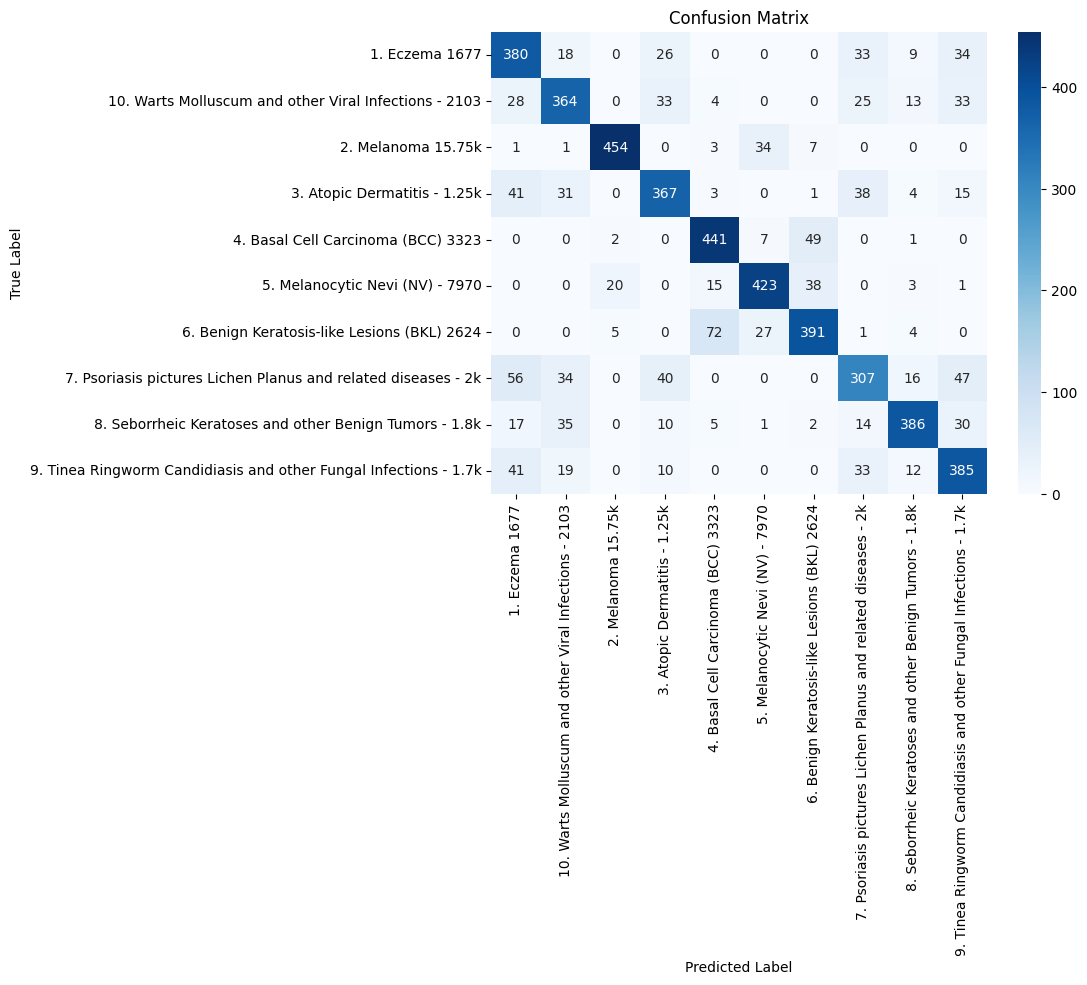

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
import os

# Path to the dataset folder (either original or processed)
DATASET_PATH = '/content/dataset_balanced/train'  # or /val or any other folder

for class_name in os.listdir(DATASET_PATH):
    class_path = os.path.join(DATASET_PATH, class_name)
    if os.path.isdir(class_path):
        count = len([
            fname for fname in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, fname))
        ])
        print(f'{class_name}: {count} images')


2. Melanoma 15.75k: 2000 images
6. Benign Keratosis-like Lesions (BKL) 2624: 2000 images
4. Basal Cell Carcinoma (BCC) 3323: 2000 images
1. Eczema 1677: 1995 images
8. Seborrheic Keratoses and other Benign Tumors - 1.8k: 2000 images
3. Atopic Dermatitis - 1.25k: 1995 images
9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k: 1998 images
7. Psoriasis pictures Lichen Planus and related diseases - 2k: 1999 images
5. Melanocytic Nevi (NV) - 7970: 2000 images
10. Warts Molluscum and other Viral Infections - 2103: 2000 images


In [ ]:
from tensorflow.keras.models import load_model

model.save("/content/drive/MyDrive/saved_model/skin_model.keras")